In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zillowhousingdata/new_construction_sales_price.csv
/kaggle/input/zillowhousingdata/median_days_to_pending.csv
/kaggle/input/zillowhousingdata/for_sale_inventory.csv
/kaggle/input/zillowhousingdata/new_construction_sales_count.csv
/kaggle/input/zillowhousingdata/sales_to_list_ratio.csv
/kaggle/input/zillowhousingdata/share_listings_price_cut.csv
/kaggle/input/zillowhousingdata/median_list_price.csv
/kaggle/input/zillowhousingdata/percent_sales_above_list.csv
/kaggle/input/zillowhousingdata/years_to_save_buy.csv
/kaggle/input/zillowhousingdata/percent_sales_below_list.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Gather Data

The data saved to CSV can be found at the site below. The goal was to gather data in a variety of areas and find the strongest permutations of clusters among them.

https://www.zillow.com/research/data/

High level summary of data

- For Sale Inventory (fsi): Number of homes for sale, indicating market supply levels.
- Median Days to Pending (d2p): Average days for a listing to go under contract, reflecting market speed and demand.
- Median List Price (lp): Median price of homes listed for sale, influenced by supply, demand, and economic factors.
- New Construction Sales Count (ncc): Number of newly constructed homes sold, offering insights into new home demand and supply.
- New Construction Sales Price (ncp): Sales prices of new homes, reflecting market trends, construction costs, and location.
- Percent Sales Above List (sal_abv_lst): Percentage of homes sold above list price, indicating high demand and competitive bidding.
- Percent Sales Below List (sal_blw_lst): Percentage of homes sold below list price, signaling lower demand or overpricing.
- Sales to List Ratio (sal_to_lst): Ratio of sale price to list price, showing how closely sales align with listing prices.
- Share Listings with Price Cut (share_lst_price_cut): Percentage of listings with reduced prices, indicating market softness.
- Years to Save to Buy (years2save): Time needed to save for a down payment, reflecting housing affordability and financial strain.

**The dataset captures housing market dynamics, including supply (inventory, new construction sales), demand (days to pending, sales above/below list), pricing (list price, price cuts), and affordability (years to save).**

In [3]:
zillow_data = {
    "fsi": pd.read_csv("/kaggle/input/zillowhousingdata/for_sale_inventory.csv"),
    "d2p": pd.read_csv("/kaggle/input/zillowhousingdata/median_days_to_pending.csv"),
    "lp": pd.read_csv("/kaggle/input/zillowhousingdata/median_list_price.csv"),
    "ncc": pd.read_csv("/kaggle/input/zillowhousingdata/new_construction_sales_count.csv"),
    "ncp": pd.read_csv("/kaggle/input/zillowhousingdata/new_construction_sales_price.csv"),
    "sal_abv_lst": pd.read_csv("/kaggle/input/zillowhousingdata/percent_sales_above_list.csv"),
    "sal_blw_lst": pd.read_csv("/kaggle/input/zillowhousingdata/percent_sales_below_list.csv"),
    "sal_to_lst": pd.read_csv("/kaggle/input/zillowhousingdata/sales_to_list_ratio.csv"),
    "share_lst_price_cut": pd.read_csv("/kaggle/input/zillowhousingdata/share_listings_price_cut.csv"),
    "years2save": pd.read_csv("/kaggle/input/zillowhousingdata/years_to_save_buy.csv")
}


Quick overview of all the dataframes. Since rows represent cities that is where the construction dfs (ncc and ncp) have less data. Structure of all is the same where columns are RegionId, SizeRank, RegionName, RegionType, StateName, then the rest being the metric for each month since 2018. RegionId is ideal choice for joining data.

In [4]:
for key, value in zillow_data.items():
    print(key, value.shape)

fsi (928, 89)
d2p (635, 89)
lp (928, 89)
ncc (292, 88)
ncp (143, 88)
sal_abv_lst (582, 88)
sal_blw_lst (582, 88)
sal_to_lst (582, 88)
share_lst_price_cut (928, 89)
years2save (382, 161)


In [5]:
for key, value in zillow_data.items():
    print(key)
    display(value.head(5))

fsi


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,102001,0,United States,country,NaN,1360757.0,1388126.0,1515705.0,1596751.0,1664788.0,...,967894.0,1031815.0,1110857.0,1160760.0,1177387.0,1182070.0,1181038.0,1182326.0,1109752.0,999059.0
1,394913,1,"New York, NY",msa,NY,66530.0,74575.0,80016.0,86445.0,91131.0,...,38575.0,41631.0,44718.0,45191.0,44606.0,41505.0,41972.0,41915.0,37299.0,31838.0
2,753899,2,"Los Angeles, CA",msa,CA,19893.0,21994.0,24106.0,25253.0,27455.0,...,15394.0,16853.0,18684.0,19834.0,20952.0,21324.0,21709.0,21786.0,19407.0,16553.0
3,394463,3,"Chicago, IL",msa,IL,34633.0,37046.0,44063.0,45649.0,47560.0,...,20312.0,21606.0,23429.0,24366.0,24746.0,25224.0,25463.0,25573.0,22503.0,18747.0
4,394514,4,"Dallas, TX",msa,TX,23048.0,23331.0,25749.0,28549.0,30376.0,...,24505.0,26568.0,28330.0,31190.0,31614.0,32090.0,31619.0,31707.0,29902.0,27073.0


d2p


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,102001,0,United States,country,NaN,47.0,25.0,20.0,18.0,18.0,...,13.0,13.0,13.0,15.0,18.0,20.0,21.0,23.0,28.0,37.0
1,394913,1,"New York, NY",msa,NY,86.0,51.0,37.0,41.0,37.0,...,21.0,22.0,21.0,24.0,27.0,27.0,29.0,29.0,32.0,41.0
2,753899,2,"Los Angeles, CA",msa,CA,21.0,14.0,15.0,14.0,15.0,...,13.0,13.0,14.0,15.0,16.0,18.0,21.0,21.0,24.0,29.0
3,394463,3,"Chicago, IL",msa,IL,57.0,23.0,15.0,14.0,15.0,...,7.0,6.0,7.0,7.0,9.0,12.0,13.0,15.0,19.0,27.0
4,394514,4,"Dallas, TX",msa,TX,37.0,24.0,21.0,19.0,20.0,...,15.0,14.0,17.0,19.0,25.0,31.0,34.0,33.0,36.0,47.0


lp


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,102001,0,United States,country,NaN,255000.0,264900.0,269900.0,279000.0,281000.0,...,394000.0,399900.0,407900.0,409900.0,400000.0,399900.0,399900.0,399000.0,390000.0,384900.0
1,394913,1,"New York, NY",msa,NY,489000.0,505000.0,515000.0,519000.0,529900.0,...,699000.0,700000.0,719999.0,719000.0,709000.0,699990.0,719900.0,725000.0,715000.0,705000.0
2,753899,2,"Los Angeles, CA",msa,CA,709000.0,725000.0,730000.0,750000.0,750000.0,...,999900.0,1049000.0,1089000.0,1099000.0,1098000.0,1074950.0,1060000.0,1050000.0,1000000.0,995000.0
3,394463,3,"Chicago, IL",msa,IL,269900.0,289000.0,294900.0,299900.0,307000.0,...,339900.0,350000.0,359900.0,359900.0,355000.0,349900.0,350000.0,340000.0,330000.0,320000.0
4,394514,4,"Dallas, TX",msa,TX,318000.0,325000.0,325990.0,334500.0,334900.0,...,424900.0,434000.0,439900.0,440000.0,435000.0,429000.0,428595.0,425000.0,420000.0,415000.0


ncc


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,102001,0,United States,country,NaN,34549.0,33830.0,43328.0,38331.0,40731.0,...,30845.0,36549.0,34406.0,36972.0,33496.0,31325.0,29820.0,25638.0,23791.0,20929.0
1,394913,1,"New York, NY",msa,NY,535.0,457.0,561.0,526.0,611.0,...,302.0,345.0,331.0,446.0,341.0,373.0,370.0,307.0,300.0,305.0
2,753899,2,"Los Angeles, CA",msa,CA,333.0,398.0,587.0,437.0,453.0,...,152.0,238.0,243.0,233.0,226.0,144.0,151.0,122.0,139.0,145.0
3,394463,3,"Chicago, IL",msa,IL,287.0,255.0,331.0,350.0,388.0,...,401.0,414.0,445.0,520.0,416.0,423.0,457.0,357.0,369.0,386.0
4,394514,4,"Dallas, TX",msa,TX,1446.0,1527.0,2065.0,1786.0,1605.0,...,1381.0,1606.0,1525.0,1508.0,1471.0,1295.0,1151.0,937.0,873.0,685.0


ncp


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,102001,0,United States,country,NaN,3.934505e+05,3.911902e+05,4.038481e+05,4.044180e+05,4.141798e+05,...,5.296691e+05,5.404652e+05,5.526917e+05,5.584909e+05,5.451539e+05,5.500350e+05,5.604203e+05,5.598643e+05,6.018721e+05,6.106816e+05
1,394913,1,"New York, NY",msa,NY,8.637209e+05,9.500317e+05,9.478868e+05,1.007924e+06,1.044523e+06,...,1.225177e+06,1.268170e+06,1.226532e+06,1.392117e+06,1.351624e+06,1.311173e+06,1.478650e+06,1.362051e+06,1.186414e+06,1.253473e+06
2,753899,2,"Los Angeles, CA",msa,CA,1.263916e+06,1.184558e+06,1.372447e+06,1.319269e+06,1.472915e+06,...,1.780527e+06,1.971883e+06,1.715970e+06,1.939092e+06,1.838947e+06,2.034956e+06,1.853920e+06,2.157495e+06,2.164212e+06,1.930005e+06
3,394463,3,"Chicago, IL",msa,IL,5.633328e+05,5.462798e+05,4.795256e+05,5.565259e+05,5.626556e+05,...,6.186401e+05,6.205554e+05,6.480867e+05,6.649891e+05,6.453028e+05,6.601053e+05,6.395662e+05,6.044174e+05,6.290674e+05,6.878705e+05
4,394514,4,"Dallas, TX",msa,TX,3.609804e+05,3.776680e+05,3.857745e+05,3.740294e+05,4.082419e+05,...,4.746603e+05,5.040611e+05,4.986102e+05,5.066577e+05,4.902143e+05,5.194326e+05,5.299514e+05,5.594734e+05,5.609853e+05,6.384842e+05


sal_abv_lst


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,102001,0,United States,country,NaN,0.201633,0.224093,0.256915,0.277738,0.293212,...,0.265968,0.302812,0.332726,0.350557,0.352854,0.332887,0.304821,0.286886,0.278308,0.269031
1,394913,1,"New York, NY",msa,NY,0.207321,0.192324,0.206443,0.226445,0.227552,...,0.419609,0.464933,0.511668,0.538900,0.569738,0.567112,0.550832,0.515526,0.507395,0.515314
2,753899,2,"Los Angeles, CA",msa,CA,0.358445,0.401495,0.444414,0.457490,0.464407,...,0.490096,0.527085,0.556657,0.567535,0.551917,0.523005,0.481089,0.458333,0.441711,0.434446
3,394463,3,"Chicago, IL",msa,IL,0.144259,0.151316,0.178789,0.202620,0.217220,...,0.348550,0.413476,0.483861,0.504670,0.519757,0.493155,0.438348,0.389291,0.355901,0.332485
4,394514,4,"Dallas, TX",msa,TX,0.239693,0.274752,0.311490,0.341781,0.345910,...,0.216854,0.249908,0.271040,0.272358,0.236026,0.210271,0.178276,0.173325,0.168150,0.164068


sal_blw_lst


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,102001,0,United States,country,NaN,0.648678,0.625301,0.583064,0.557316,0.538843,...,0.544107,0.506098,0.475249,0.459182,0.455409,0.474167,0.502436,0.518096,0.528212,0.541562
1,394913,1,"New York, NY",msa,NY,0.684859,0.698018,0.678559,0.662688,0.660681,...,0.464696,0.418971,0.375881,0.358188,0.323874,0.331399,0.346309,0.377895,0.382412,0.378720
2,753899,2,"Los Angeles, CA",msa,CA,0.505873,0.472217,0.419172,0.413514,0.406703,...,0.383697,0.348752,0.324702,0.316250,0.333654,0.353438,0.394309,0.412541,0.437121,0.439612
3,394463,3,"Chicago, IL",msa,IL,0.772883,0.766917,0.726891,0.694540,0.680928,...,0.509458,0.450638,0.378006,0.365978,0.353886,0.368818,0.416898,0.457148,0.490316,0.511620
4,394514,4,"Dallas, TX",msa,TX,0.591173,0.543654,0.509893,0.469363,0.471630,...,0.582756,0.517968,0.511360,0.501807,0.536469,0.560829,0.607069,0.618442,0.619769,0.642873


sal_to_lst


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30
0,102001,0,United States,country,NaN,0.981818,0.983730,0.987496,0.990099,0.992308,...,0.990294,0.997135,1.000000,1.000000,1.000000,1.000000,0.998331,0.994344,0.992593,0.990698
1,394913,1,"New York, NY",msa,NY,0.977995,0.976219,0.978495,0.979499,0.980645,...,1.000000,1.000000,1.000270,1.006061,1.013514,1.011702,1.008432,1.000469,1.000008,1.000200
2,753899,2,"Los Angeles, CA",msa,CA,0.997673,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000256,1.004184,1.006408,1.002895,1.000200,1.000000,1.000000,1.000000,1.000000
3,394463,3,"Chicago, IL",msa,IL,0.971238,0.972319,0.976196,0.979367,0.981132,...,0.995332,1.000000,1.000000,1.000048,1.000286,1.000000,1.000000,1.000000,1.000000,0.995276
4,394514,4,"Dallas, TX",msa,TX,0.987746,0.992433,0.996814,1.000000,1.000000,...,0.988149,0.994948,0.996667,0.999128,0.993333,0.990753,0.987124,0.986667,0.985714,0.984127


share_lst_price_cut


,RegionID,SizeRank,RegionName,RegionType,StateName,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,102001,0,United States,country,NaN,0.147669,0.139205,0.153134,0.162307,0.185487,...,0.205619,0.223926,0.237981,0.244289,0.262164,0.258815,0.250387,0.247935,0.218009,0.171971
1,394913,1,"New York, NY",msa,NY,0.125282,0.112987,0.122063,0.149563,0.173783,...,0.110616,0.123994,0.137394,0.141953,0.143411,0.131984,0.157486,0.148944,0.120593,0.084333
2,753899,2,"Los Angeles, CA",msa,CA,0.148645,0.136310,0.157305,0.169089,0.198798,...,0.145381,0.149944,0.180850,0.184885,0.206138,0.208920,0.208024,0.217846,0.183387,0.132665
3,394463,3,"Chicago, IL",msa,IL,0.193284,0.175242,0.200803,0.240246,0.274916,...,0.165863,0.187355,0.210679,0.221702,0.254102,0.259475,0.273731,0.284050,0.239879,0.177682
4,394514,4,"Dallas, TX",msa,TX,0.178063,0.146886,0.174182,0.186732,0.224750,...,0.253948,0.290387,0.319026,0.349471,0.373917,0.346712,0.328031,0.319803,0.281051,0.226831


years2save


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,RegionID,SizeRank,RegionName,RegionType,StateName,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,102001,0,United States,country,NaN,6.148093,6.135881,6.134029,6.137998,6.145549,...,8.846064,8.868391,8.880261,8.871221,8.852161,8.835169,8.823709,8.838125,8.850202,8.867839
1,394913,1,"New York, NY",msa,NY,11.499500,11.463933,11.447519,11.447641,11.458631,...,13.338373,13.428316,13.488194,13.516482,13.537976,13.579083,13.626312,13.697910,13.754197,13.790445
2,753899,2,"Los Angeles, CA",msa,CA,NaN,NaN,NaN,NaN,NaN,...,19.317819,19.338819,19.410802,19.443378,19.484865,19.542160,19.625666,19.734002,19.827345,19.910779
3,394463,3,"Chicago, IL",msa,IL,5.739043,5.679805,5.639373,5.601358,5.567925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,394514,4,"Dallas, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,8.462567,8.461744,8.442453,8.405753,8.363206,8.326950,8.301338,8.298978,8.292553,8.280876


# EDA - Inspect, Visualize, Clean Data

We are using 11-30-2023 for consistency and best data availability. Dropping NaN values, they are associated with smaller cities and best way to handle incomplete data. Iterating over all dataframes to see shape for all with 11-30-2023 date. Results below help understand which dataframes are ideal to use. New construction (ncc and ncp) dataframes would decrease the amount of cities on joining so will not use those metrics.

In [6]:
for key, df in zillow_data.items():
    filtered_df = df.iloc[:, :5].join(df.filter(like="2023-11-30"))
    filtered_df = filtered_df.dropna()
    zillow_data[key] = filtered_df

In [7]:
for key, df in zillow_data.items():
    display(key, df.shape)

'fsi'

(927, 6)

'd2p'

(546, 6)

'lp'

(923, 6)

'ncc'

(251, 6)

'ncp'

(132, 6)

'sal_abv_lst'

(489, 6)

'sal_blw_lst'

(489, 6)

'sal_to_lst'

(489, 6)

'share_lst_price_cut'

(924, 6)

'years2save'

(353, 6)

Electing to exclude new construction data as it limits the amount of usable data on joins. Removing redundant columns for each dataframe.

In [8]:
combined_df = zillow_data["fsi"]
combined_df.columns = ["fsi" if "2023-11-30" in col else col for col in combined_df.columns]

df_exclusions = ["ncc", "ncp", "fsi"]
redundant_columns = ['SizeRank', 'RegionName', 'RegionType', 'StateName']
for key, df in zillow_data.items():
    df = df.drop(columns = redundant_columns)
    if key not in df_exclusions:
        df = df.rename(columns={col: f"{col}_{key}" for col in df.columns if col != "RegionID"})
        combined_df = pd.merge(combined_df, df, on="RegionID", how="inner")
        
# Remove "-11-30" if it appears in column names
combined_df.columns = [col.replace("2023-11-30_", "") for col in combined_df.columns]

Confirming joined data is cleaned and output matches shape. Describe data helps understanding of basic metrics.

In [9]:
print(combined_df.columns)
print(combined_df.shape)
display(combined_df.head(10))

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'fsi',
       'd2p', 'lp', 'sal_abv_lst', 'sal_blw_lst', 'sal_to_lst',
       'share_lst_price_cut', 'years2save'],
      dtype='object')
(318, 13)


,RegionID,SizeRank,RegionName,RegionType,StateName,fsi,d2p,lp,sal_abv_lst,sal_blw_lst,sal_to_lst,share_lst_price_cut,years2save
0,394913,1,"New York, NY",msa,NY,40601.0,30.0,695000.0,0.500154,0.390683,1.000000,0.130736,13.189570
1,753899,2,"Los Angeles, CA",msa,CA,15367.0,17.0,998000.0,0.485912,0.395893,1.000000,0.177133,19.500829
2,394463,3,"Chicago, IL",msa,IL,21499.0,14.0,325000.0,0.360589,0.488553,1.000000,0.240755,7.008667
3,394514,4,"Dallas, TX",msa,TX,22881.0,27.0,424067.0,0.206930,0.590231,0.987013,0.295485,8.527950
4,394692,5,"Houston, TX",msa,TX,22597.0,28.0,350000.0,0.155077,0.643663,0.982353,0.246670,7.700226
5,395209,6,"Washington, DC",msa,VA,9980.0,14.0,549000.0,0.384783,0.361141,1.000000,0.226754,8.612204
6,394974,7,"Philadelphia, PA",msa,PA,12471.0,14.0,319000.0,0.435174,0.386460,1.000000,0.237270,7.883915
7,394856,8,"Miami, FL",msa,FL,35646.0,29.0,550000.0,0.137728,0.713446,0.972727,0.216574,12.314017
8,394347,9,"Atlanta, GA",msa,GA,20430.0,26.0,375000.0,0.248925,0.516064,0.995349,0.256632,8.312330
9,394404,10,"Boston, MA",msa,MA,7213.0,11.0,739900.0,0.535391,0.367217,1.001252,0.198530,11.765489


In [10]:
columns_to_exclude = ["RegionID", "SizeRank", "RegionName", "RegionType", "StateName"]
columns_to_plot = [col for col in combined_df.columns if col not in columns_to_exclude]
summary = combined_df[columns_to_plot].describe()
display(summary)

,fsi,d2p,lp,sal_abv_lst,sal_blw_lst,sal_to_lst,share_lst_price_cut,years2save
count,318.000000,318.000000,3.180000e+02,318.000000,318.000000,318.000000,318.000000,318.000000
mean,2322.421384,22.333333,3.752844e+05,0.267444,0.535639,0.989718,0.228379,8.705514
std,4487.445666,9.786469,2.023880e+05,0.126715,0.119914,0.012291,0.041357,3.130355
min,135.000000,7.000000,9.990000e+04,0.049296,0.182442,0.947868,0.109529,3.582219
25%,422.000000,14.250000,2.500000e+05,0.174603,0.463396,0.981415,0.197409,6.612348
50%,896.000000,21.000000,3.290000e+05,0.242670,0.540564,0.990513,0.229465,8.050486
75%,1979.250000,28.000000,4.299750e+05,0.346871,0.616667,1.000000,0.256527,10.079478
max,40601.000000,59.000000,1.450000e+06,0.729767,0.823899,1.061765,0.329113,23.906365


Histogram findings
* Share_lst_price_cut and sal_blw_lst are symmetrical.
* Many other dataframes are skewed.
* Fsi is a bit of an outlier in the shape, spread

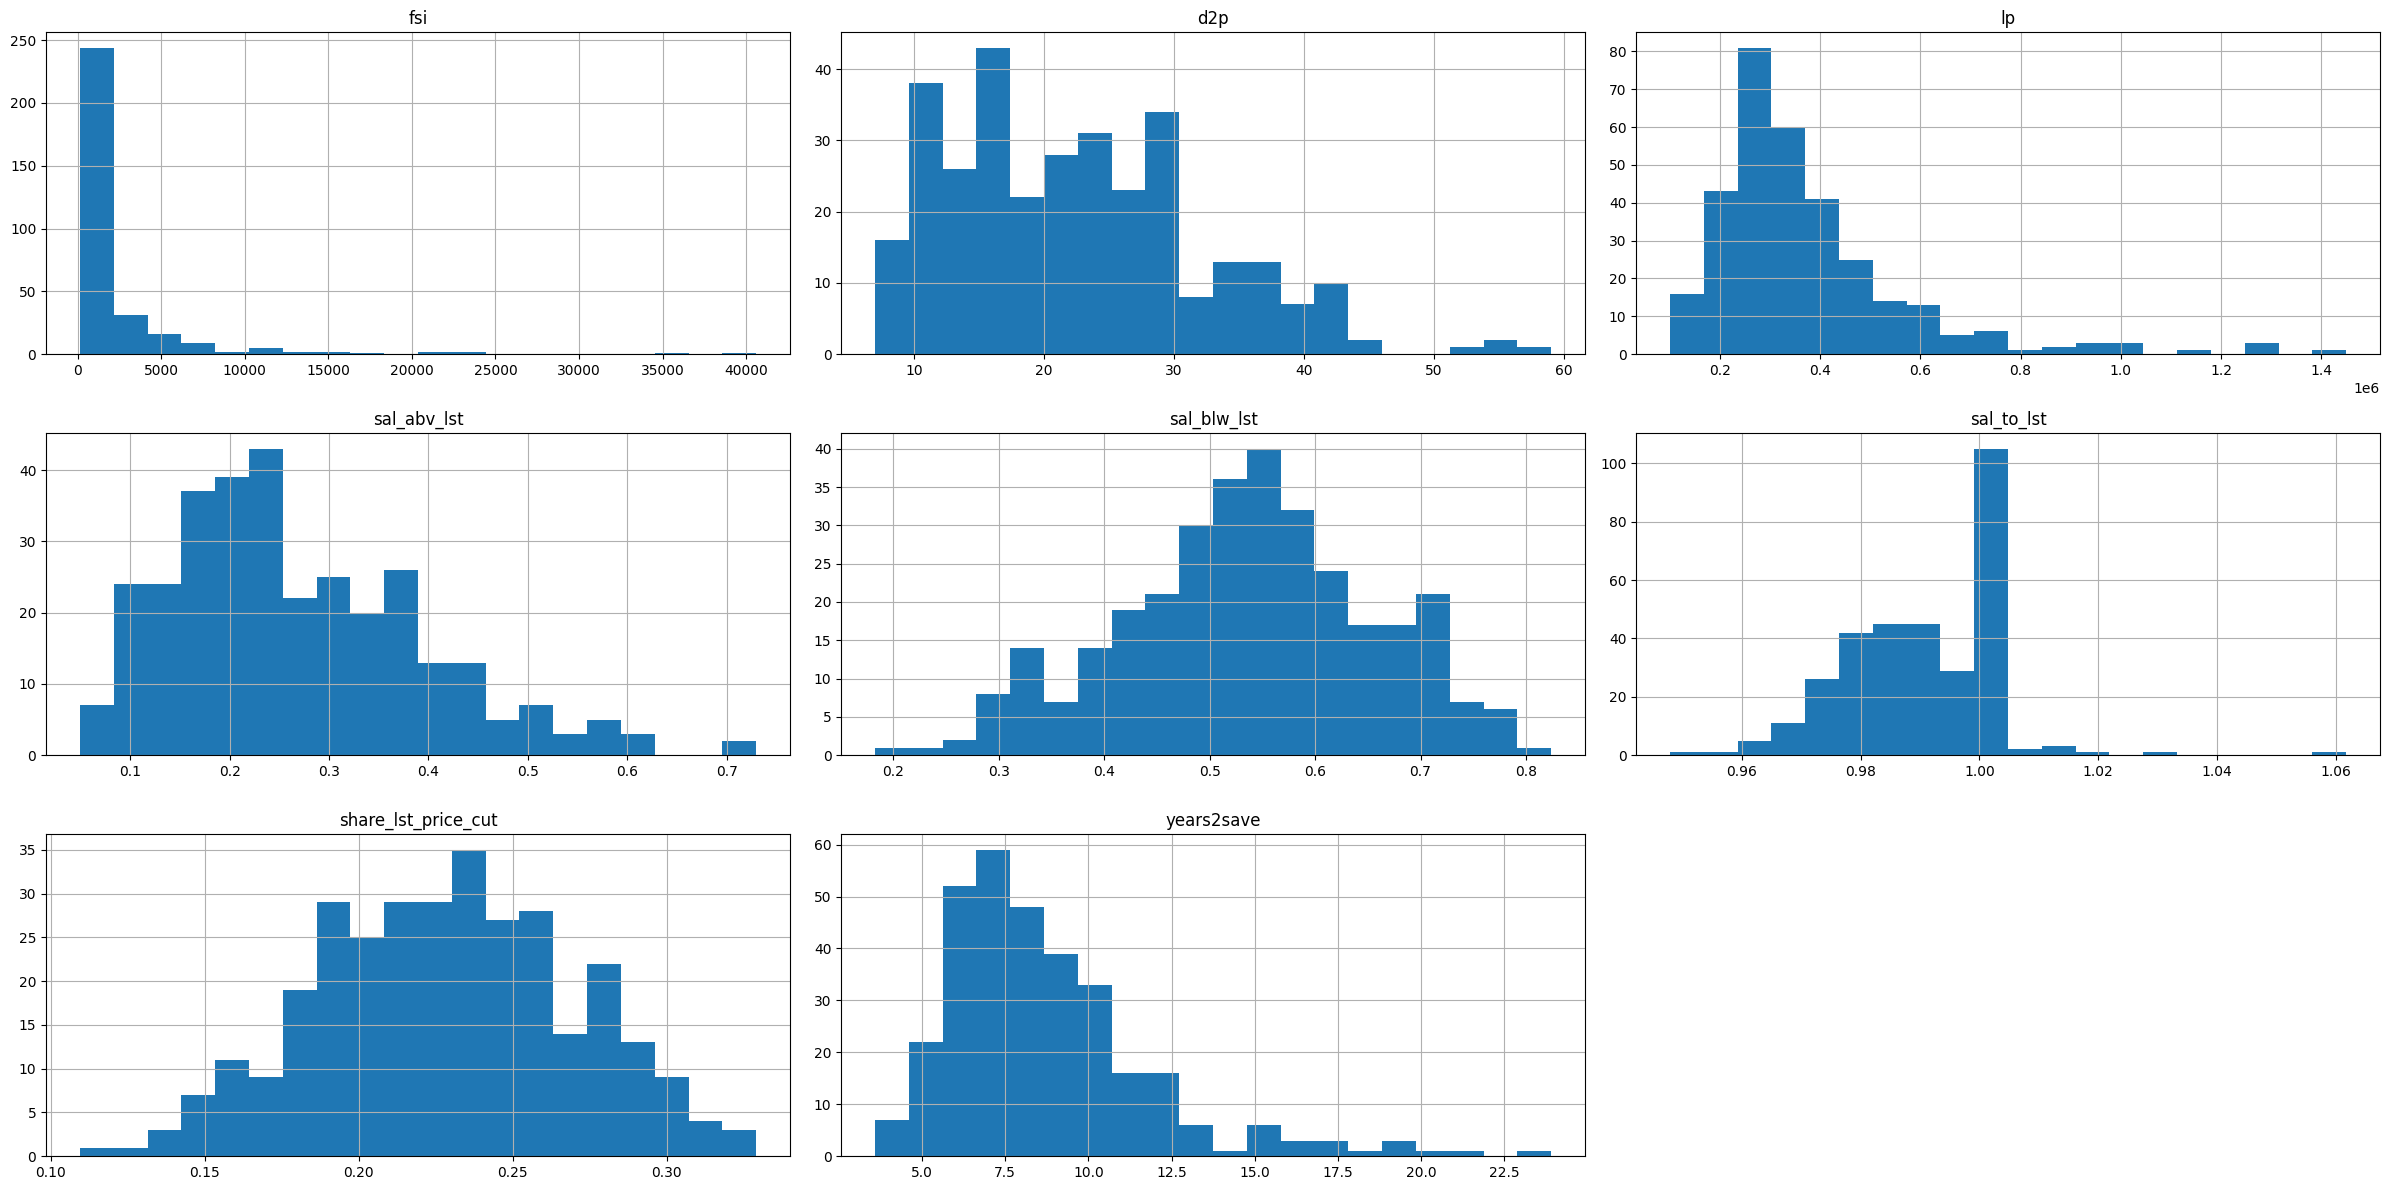

In [11]:
if columns_to_plot:
    combined_df[columns_to_plot].hist(bins=20, figsize=(len(columns_to_plot) * 3, 12))
    plt.tight_layout()
    plt.show()

Boxplot findings


* Share_lst_price_cut, sal_to_lst, sal_blw_lst, and sal_abv_lst all have low amount of outliers 
* Fsi,years2save, and lp all have a large amount of outliers

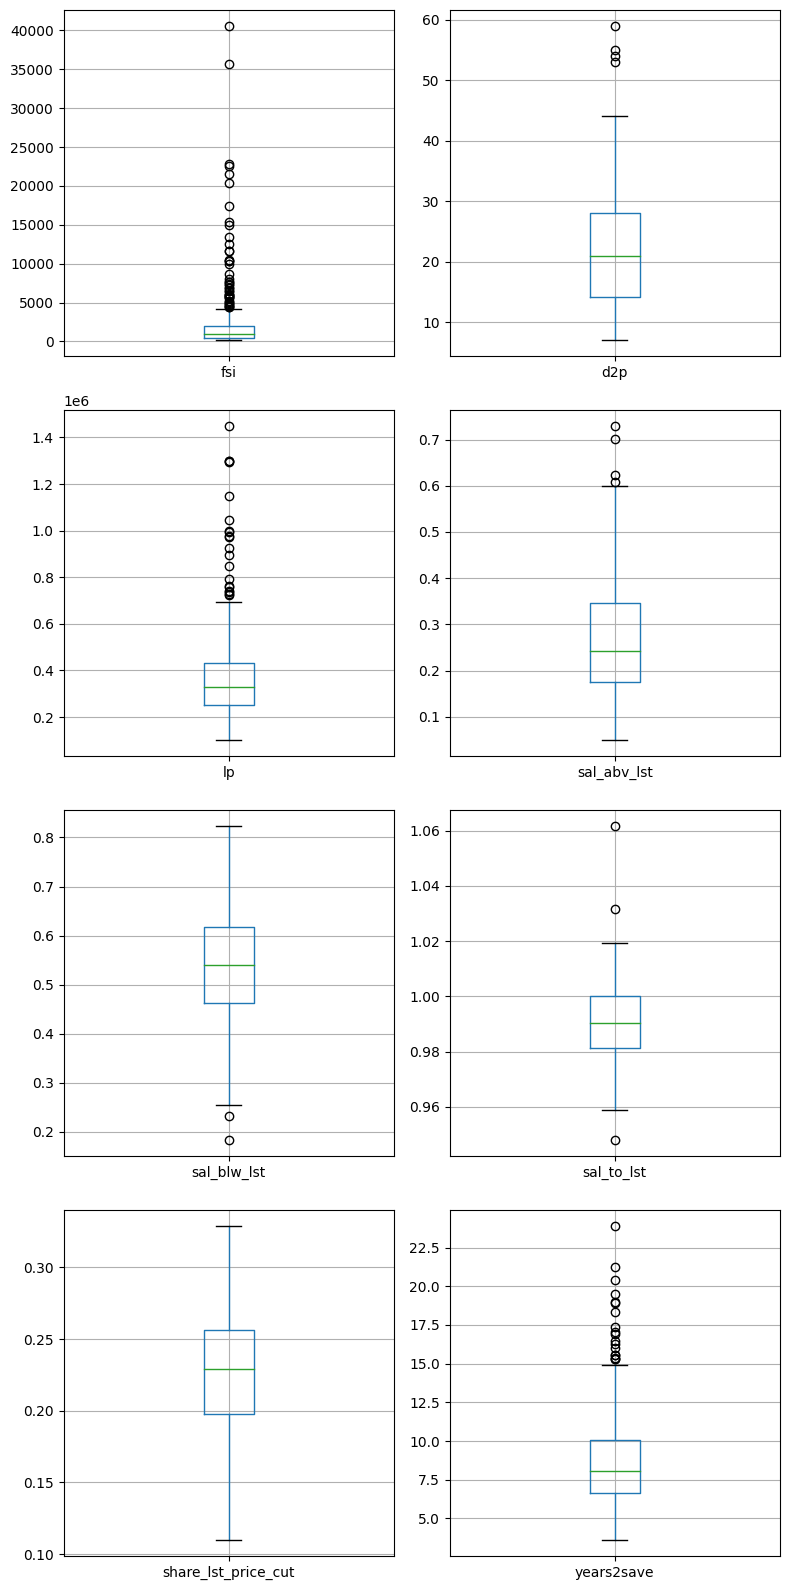

In [12]:
if columns_to_plot:
    fig, axes = plt.subplots(nrows=len(columns_to_plot) // 2 + len(columns_to_plot) % 2, ncols=2, figsize=(8, len(columns_to_plot) * 2))
    axes = axes.flatten() if len(columns_to_plot) > 1 else [axes]
    for ax, col in zip(axes, columns_to_plot):
        combined_df[[col]].boxplot(ax=ax)
    for i in range(len(columns_to_plot), len(axes)):  
        axes[i].axis("off")  
    plt.tight_layout()
    plt.show()

Given above and the outliers between fsi, lp, and years2save we will perform a log transform. The boxplots and histograms now look more reasonable and with a normal distribution.

         fsi         lp  years2save
0  10.611573  13.451669    2.652507
1   9.640043  13.813510    3.020465
2   9.975808  12.691584    2.080524
3  10.038106  12.957649    2.254230
4  10.025617  12.765691    2.163349


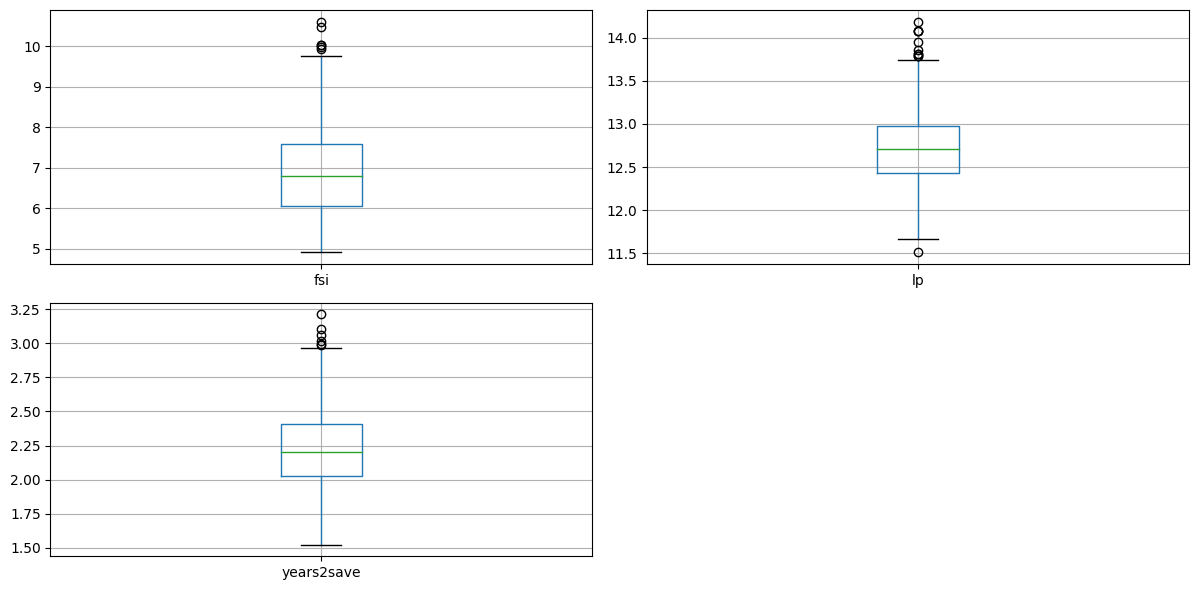

In [13]:
combined_df['fsi'] = np.log(combined_df['fsi'] + 1)
combined_df['lp'] = np.log(combined_df['lp'] + 1)
combined_df['years2save'] = np.log(combined_df['years2save'] + 1)

print(combined_df[['fsi', 'lp', 'years2save']].head())
log_transform = ['fsi', 'lp', 'years2save']

if log_transform:
    fig, axes = plt.subplots(nrows=len(log_transform) // 2 + len(log_transform) % 2, ncols=2, figsize=(12, len(log_transform) * 2))
    axes = axes.flatten() if len(log_transform) > 1 else [axes]
    for ax, col in zip(axes, log_transform):
        combined_df[[col]].boxplot(ax=ax)
    for i in range(len(log_transform), len(axes)):  
        axes[i].axis("off") 
    plt.tight_layout()
    plt.show()

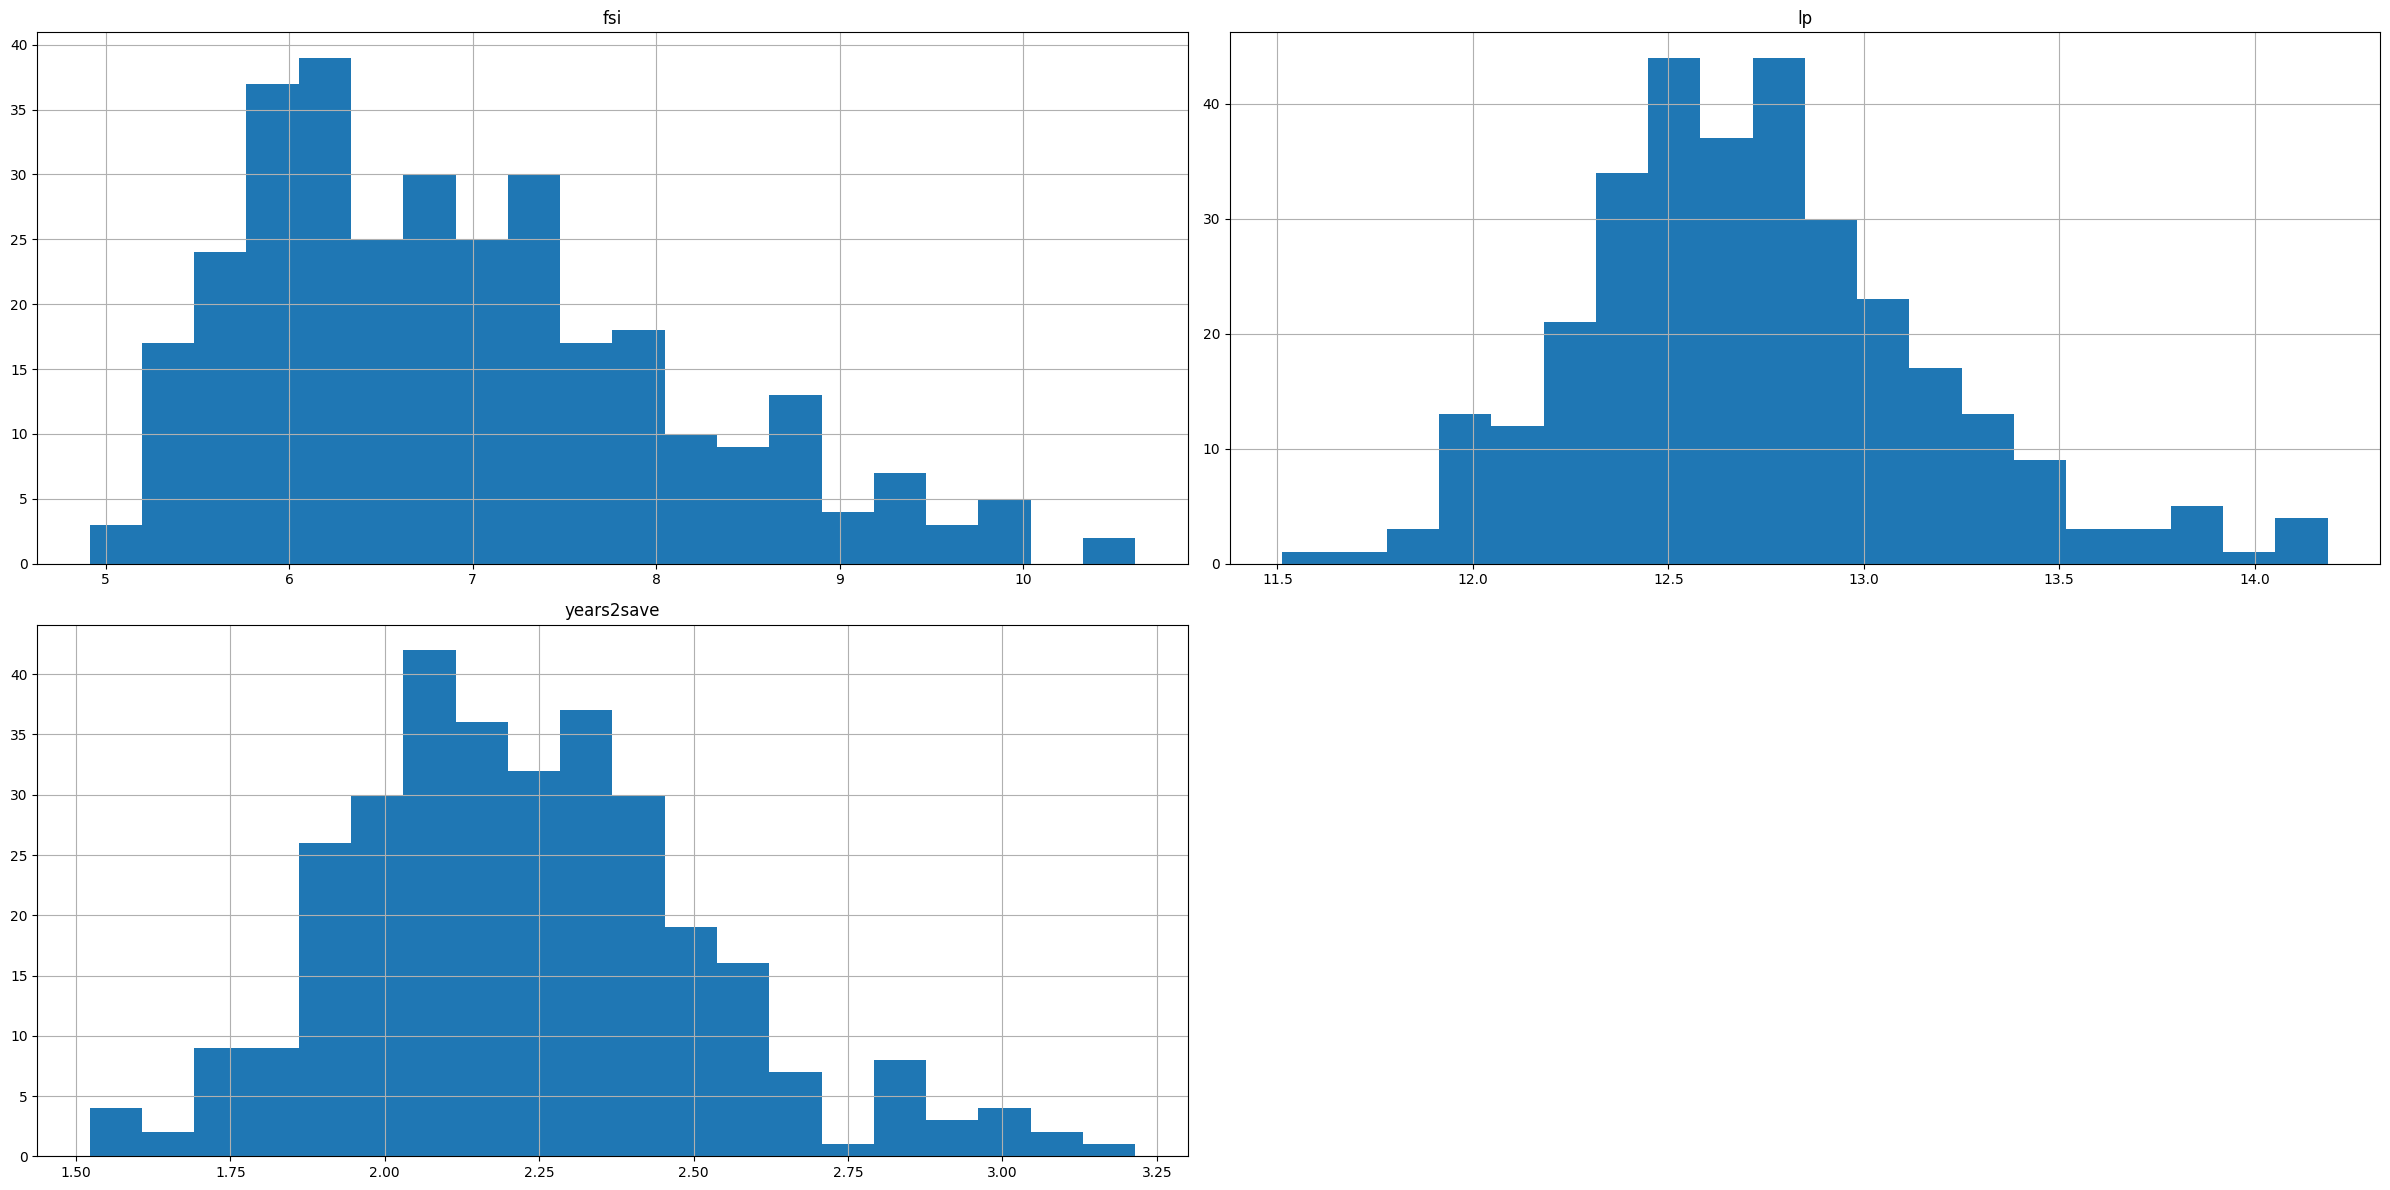

In [14]:
if log_transform:
    combined_df[log_transform].hist(bins=20, figsize=(len(columns_to_plot) * 3, 12))
    plt.tight_layout()
    plt.show()

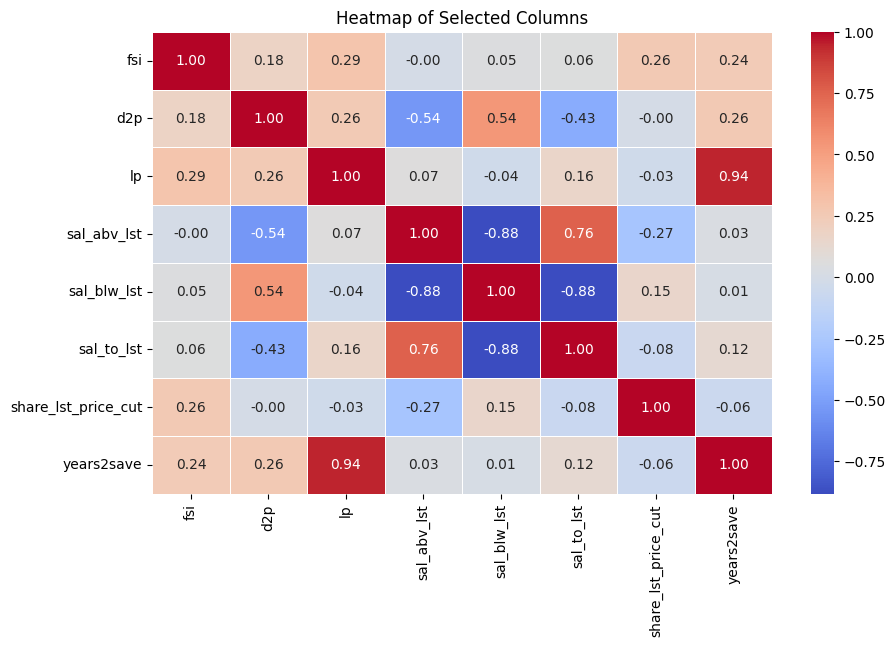

In [15]:
if columns_to_plot:
    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap_data = combined_df[columns_to_plot].corr()
    sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=ax)
    plt.title("Heatmap of Selected Columns")
    plt.show()

Matrix was useful in removing correlated fields. Sales_above_list and sales_below_list are inversely correlated for obvious reasons. Sale_to_list_ratio was highly correlated with both sales_above_list and sales_below_list. When thinking about sales_to_list_ratio it is essentially a way of combining both. Listing price and years to save were also highly correlated which makes sense. I will iteratively remove fields. 

Certain factors are more important because I would like to have a variety of features between their category of supply, demand, pricing, affordability. I am electing to keep both years2save and list price despite the high correlation. They are slightly different in that years2save is relative while list price is absolute. I also iterate over every permutation later so have the ability to ignore this combination.

# Perform Analysis Using Unsupervised Learning Models of Your Choice, Present Discussion, and Conclusions 

In [16]:
columns_to_include = ['fsi', 'd2p', 'lp', 'sal_to_lst','share_lst_price_cut', 'years2save']
region_ids = combined_df['RegionID']
region_names = combined_df['RegionName']
combined_df = combined_df[columns_to_include]
combined_df.shape

(318, 6)

Start with Kmeans model and dictionary of hyperparams. I found that at lower cluster numbers I was getting the same accuracy scores despite different hyperparams so I adjusted the minimum number of clusters to 3, I did not find having 2 clusters to be beneficial as its oversimplified.


The max_iter and tol started lower for Kmeans but the computational time was manageable where I felt higher iterations could be tolerated. Many combinations below produced the same score result when the permutation was the same but one or more of the hyperparameters was different.

In [17]:
X = combined_df
min_features = 3
max_features = len(X.columns)
min_clusters = 3
max_clusters = 15
results = []
hyperparams = {
    'n_init': [20],
    'max_iter': [300, 1000],
    'init': ['k-means++'],
    'algorithm': ['lloyd', 'elkan'],
    'tol': [1e-4, 1e-6],
}
for num_features in range(min_features, max_features + 1):
    for cols in itertools.combinations(X.columns, num_features):
        X_subset = X[list(cols)]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_subset)
        for k in range(min_clusters, max_clusters):
            for tol in hyperparams['tol']:
                for n_init in hyperparams['n_init']:
                    for max_iter in hyperparams['max_iter']:
                        for init in hyperparams['init']:
                            for algorithm in hyperparams['algorithm']:
                                        kmeans = KMeans(
                                            n_clusters=k,
                                            n_init=n_init,
                                            max_iter=max_iter,
                                            init=init,
                                            algorithm=algorithm
                                        )
                                        labels = kmeans.fit_predict(X_scaled)
                                        wcss = kmeans.inertia_
                                        sil_score = silhouette_score(X_scaled, labels)
                                        db_score = davies_bouldin_score(X_scaled, labels)
                                        ch_score = calinski_harabasz_score(X_scaled, labels)
                                        
                                        results.append({
                                            "columns": cols,
                                            "k": k,
                                            "n_init": n_init,
                                            "max_iter": max_iter,
                                            "init": init,
                                            "algorithm": algorithm,
                                            "tol": tol,
                                            "WCSS": wcss,
                                            "Silhouette": sil_score,
                                            "Davies-Bouldin": db_score,
                                            "Calinski-Harabasz": ch_score
                                        })
k_means_df = pd.DataFrame(results)

Much of below follows the same pattern as above with hyperparams, iterating over combinations of features, scaling, then testing accuracy with the unsupervised model.

There are naturally fewer combination of hyperparameters to test against with AgglomerativeClustering. Despite fewer combinations, the metric and linkage parameters will provide much different results than the hyperparams in KMeans. 

In [18]:
X = combined_df
min_features = 3
max_features = len(X.columns)
min_clusters = 3
max_clusters = 15
results = []

hyperparams = {
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'linkage': ['ward', 'complete', 'average']
}

for num_features in range(min_features, max_features + 1):
    for cols in itertools.combinations(X.columns, num_features):
        X_subset = X[list(cols)]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_subset)
        for k in range(min_clusters, max_clusters):
            for metric in hyperparams['metric']:
                for linkage in hyperparams['linkage']:
                    if linkage == 'ward' and metric != 'euclidean':
                        continue
    
                    clustering = AgglomerativeClustering(
                        n_clusters=k,
                        metric=metric,
                        linkage=linkage
                    )
                    labels = clustering.fit_predict(X_scaled)
                    sil_score = silhouette_score(X_scaled, labels)
                    db_score = davies_bouldin_score(X_scaled, labels)
                    ch_score = calinski_harabasz_score(X_scaled, labels)
                    results.append({
                        "columns": cols,
                        "k": k,
                        "metric": metric,
                        "linkage": linkage,
                        "Silhouette": sil_score,
                        "Davies-Bouldin": db_score,
                        "Calinski-Harabasz": ch_score
                    })
agglo_df = pd.DataFrame(results)

In [19]:
def get_best_avg_scores(df):
    return {
        "Silhouette": df["Silhouette"].nlargest(20).mean(),
        "Davies-Bouldin": df["Davies-Bouldin"].nsmallest(20).mean(),
        "Calinski-Harabasz": df["Calinski-Harabasz"].nlargest(20).mean()
    }

k_means_best_scores = get_best_avg_scores(k_means_df)
agglo_best_scores = get_best_avg_scores(agglo_df)

print("K-Means Best Scores:", k_means_best_scores)
print("Agglomerative Best Scores:", agglo_best_scores)

K-Means Best Scores: {'Silhouette': 0.3620552981849119, 'Davies-Bouldin': 0.7862011815995642, 'Calinski-Harabasz': 241.6762270598962}
Agglomerative Best Scores: {'Silhouette': 0.41753360998333794, 'Davies-Bouldin': 0.4744569466453473, 'Calinski-Harabasz': 207.19254939766748}


Clustering Model Comparison

1. Silhouette Score (Higher is Better)
- K-Means: 0.3622
- Agglomerative: 0.4175
- Conclusion: Agglomerative clustering produces more well-defined clusters, meaning data points are more tightly packed within their clusters and better separated from other clusters compared to K-Means.

2. Davies-Bouldin Index (Lower is Better)
- K-Means: 0.7844
- Agglomerative: 0.4745
- Conclusion: Agglomerative clustering has a significantly lower Davies-Bouldin score, indicating that clusters are more distinct from each other, with less overlap and tighter internal cohesion compared to K-Means.

3. Calinski-Harabasz Score (Higher is Better)
- K-Means: 241.5891
- Agglomerative: 207.1925
- Conclusion: K-Means performs better in terms of the Calinski-Harabasz score, suggesting that its clusters are more compact and well-separated in terms of variance between and within clusters.

Summary
- Agglomerative clustering outperforms K-Means in Silhouette Score and Davies-Bouldin Index, meaning it produces more distinct and better-separated clusters.
- K-Means has a higher Calinski-Harabasz score. This suggests that it might be better at keeping clusters compact, but this is outweighed by its weaker performance in the other two metrics.
- Overall, Agglomerative clustering is performing better at creating well-separated, distinct clusters, making it the stronger choice in this case.


Clustering Performance Analysis

Agglomerative clustering works better for Silhouette Score and Davies-Bouldin Index because:
- It handles uneven feature distributions better.
- It does not assume spherical clusters.
- It adapts to varying densities in the dataset.

K-Means wins on Calinski-Harabasz because:
- It optimizes variance minimization directly.
- It works well for globally compact clusters.

I added a second summary table of the k-means table filtered and does not contain lp and years2save. The correlation was high intially and this combination is dominating the df of top silhouette scores.

The last dataframe is filtered where there must be more than three features. The k-means and agglomerative clustering were predominately rows with three features, I wanted to investigate how more features would turn out with PCA.


**The selections to plot and further investigate are below along with the rationale.**
* K-Means with reasonable cluster count. WCSS higher than other optionsselected_row = k_means_df.iloc[1152]
* K-Means with a bit higher cluster count. Most well rounded score within k-means.selected_row = k_means_df.iloc[1715]
* K-Means with a cluster count between previous choices. This option excludes both lp AND years2saveselected_row = k_means_df.iloc[1002]
* Hierarchial clustering with best scores.selected_row = agglo_df.iloc[590]
* Hierarchial clustering with more than three features.selected_row = agglo_df.iloc[1684]
* K-Means with more than three features and the best score.selected_row = k_means_df.iloc[2980]

In [20]:
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', None)

print(f'K-Mean Clustering Results')
display(k_means_df.sort_values(by="Silhouette", ascending=False).head(30))

print(f'Hierarchical Clustering Results')
display(agglo_df.sort_values(by="Silhouette", ascending=False).head(30))

print(f'K-Mean Clustering Without Lp AND Years2save')
display(k_means_df[~k_means_df['columns'].apply(lambda x: 'lp' in x and 'years2save' in x)].sort_values(by="Silhouette", ascending=False).head(30))

print(f'K-Mean Clustering With More than Three Features')
display(k_means_df[k_means_df['columns'].apply(lambda x: len(x) > 3)].sort_values(by="Silhouette", ascending=False).head(30))

K-Mean Clustering Results


,columns,k,n_init,max_iter,init,algorithm,tol,WCSS,Silhouette,Davies-Bouldin,Calinski-Harabasz
1713,"(lp, sal_to_lst, years2save)",13,20,300,k-means++,elkan,0.000100,103.713053,0.368232,0.766209,208.377435
1159,"(d2p, lp, years2save)",3,20,1000,k-means++,elkan,0.000001,380.290570,0.367279,0.983915,237.605774
1154,"(d2p, lp, years2save)",3,20,1000,k-means++,lloyd,0.000100,380.290570,0.367279,0.983915,237.605774
1155,"(d2p, lp, years2save)",3,20,1000,k-means++,elkan,0.000100,380.290570,0.367279,0.983915,237.605774
1158,"(d2p, lp, years2save)",3,20,1000,k-means++,lloyd,0.000001,380.290570,0.367279,0.983915,237.605774
1157,"(d2p, lp, years2save)",3,20,300,k-means++,elkan,0.000001,380.290570,0.367279,0.983915,237.605774
1156,"(d2p, lp, years2save)",3,20,300,k-means++,lloyd,0.000001,380.290570,0.367279,0.983915,237.605774
1153,"(d2p, lp, years2save)",3,20,300,k-means++,elkan,0.000100,380.290570,0.367279,0.983915,237.605774
1152,"(d2p, lp, years2save)",3,20,300,k-means++,lloyd,0.000100,380.290570,0.367279,0.983915,237.605774
1707,"(lp, sal_to_lst, years2save)",12,20,1000,k-means++,elkan,0.000100,113.334821,0.361779,0.817452,206.342381


Hierarchical Clustering Results


,columns,k,metric,linkage,Silhouette,Davies-Bouldin,Calinski-Harabasz
590,"(fsi, sal_to_lst, share_lst_price_cut)",3,euclidean,average,0.469378,0.341678,9.575021
1430,"(lp, sal_to_lst, years2save)",3,euclidean,average,0.462215,0.581598,48.216290
1178,"(d2p, sal_to_lst, years2save)",3,euclidean,average,0.445423,0.346321,9.153393
86,"(fsi, d2p, sal_to_lst)",3,euclidean,average,0.442108,0.497786,11.894048
1429,"(lp, sal_to_lst, years2save)",3,euclidean,complete,0.440165,0.576012,63.890168
1432,"(lp, sal_to_lst, years2save)",3,manhattan,average,0.429981,0.485737,19.185442
842,"(d2p, lp, sal_to_lst)",3,euclidean,average,0.424290,0.559536,16.427240
1180,"(d2p, sal_to_lst, years2save)",3,manhattan,average,0.420274,0.533706,16.308191
1346,"(lp, sal_to_lst, share_lst_price_cut)",3,euclidean,average,0.418602,0.352858,9.481740
1348,"(lp, sal_to_lst, share_lst_price_cut)",3,manhattan,average,0.418602,0.352858,9.481740


K-Mean Clustering Without Lp AND Years2save


,columns,k,n_init,max_iter,init,algorithm,tol,WCSS,Silhouette,Davies-Bouldin,Calinski-Harabasz
1005,"(d2p, lp, sal_to_lst)",8,20,300,k-means++,elkan,0.000001,243.278325,0.323752,0.963406,129.377811
1001,"(d2p, lp, sal_to_lst)",8,20,300,k-means++,elkan,0.000100,245.702593,0.322777,0.968135,127.664329
1004,"(d2p, lp, sal_to_lst)",8,20,300,k-means++,lloyd,0.000001,243.237776,0.317263,0.958589,129.406761
1000,"(d2p, lp, sal_to_lst)",8,20,300,k-means++,lloyd,0.000100,243.745037,0.315447,0.972869,129.045287
1388,"(d2p, sal_to_lst, years2save)",8,20,300,k-means++,lloyd,0.000001,245.560999,0.314523,1.001219,127.763478
1002,"(d2p, lp, sal_to_lst)",8,20,1000,k-means++,lloyd,0.000100,247.102126,0.313741,1.040902,126.690441
484,"(fsi, lp, share_lst_price_cut)",3,20,300,k-means++,lloyd,0.000001,500.919302,0.313628,1.121711,142.458495
486,"(fsi, lp, share_lst_price_cut)",3,20,1000,k-means++,lloyd,0.000001,500.919302,0.313628,1.121711,142.458495
481,"(fsi, lp, share_lst_price_cut)",3,20,300,k-means++,elkan,0.000100,500.919302,0.313628,1.121711,142.458495
999,"(d2p, lp, sal_to_lst)",7,20,1000,k-means++,elkan,0.000001,268.827741,0.313024,0.988924,132.109737


K-Mean Clustering With More than Three Features


,columns,k,n_init,max_iter,init,algorithm,tol,WCSS,Silhouette,Davies-Bouldin,Calinski-Harabasz
2977,"(d2p, lp, sal_to_lst, years2save)",3,20,300,k-means++,elkan,0.000100,644.349702,0.303998,1.122357,153.418123
2983,"(d2p, lp, sal_to_lst, years2save)",3,20,1000,k-means++,elkan,0.000001,644.349702,0.303998,1.122357,153.418123
2979,"(d2p, lp, sal_to_lst, years2save)",3,20,1000,k-means++,elkan,0.000100,644.349702,0.303998,1.122357,153.418123
2978,"(d2p, lp, sal_to_lst, years2save)",3,20,1000,k-means++,lloyd,0.000100,644.349702,0.303998,1.122357,153.418123
2980,"(d2p, lp, sal_to_lst, years2save)",3,20,300,k-means++,lloyd,0.000001,644.349702,0.303998,1.122357,153.418123
2981,"(d2p, lp, sal_to_lst, years2save)",3,20,300,k-means++,elkan,0.000001,644.349702,0.303998,1.122357,153.418123
2982,"(d2p, lp, sal_to_lst, years2save)",3,20,1000,k-means++,lloyd,0.000001,644.349702,0.303998,1.122357,153.418123
2976,"(d2p, lp, sal_to_lst, years2save)",3,20,300,k-means++,lloyd,0.000100,644.347691,0.303273,1.131462,153.419094
2691,"(fsi, lp, share_lst_price_cut, years2save)",3,20,1000,k-means++,elkan,0.000100,641.555148,0.295174,1.159576,154.772453
2688,"(fsi, lp, share_lst_price_cut, years2save)",3,20,300,k-means++,lloyd,0.000100,641.555148,0.295174,1.159576,154.772453


In [21]:
k_means_df_by_k = k_means_df.groupby('k')[['WCSS', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']].mean()
display(k_means_df_by_k)

k_means_df_by_k_cols = k_means_df.groupby(['columns', 'k'])[['WCSS', 'Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']].mean()
k_means_df_by_k_cols = k_means_df_by_k_cols.sort_values(by='Silhouette', ascending=False).head(20)
display(k_means_df_by_k_cols)


agglo_df_by_k = agglo_df.groupby('k')[['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']].mean()
display(agglo_df_by_k)

agglo_df_by_k_cols = agglo_df.groupby(['columns', 'k'])[['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']].mean()
agglo_df_by_k_cols = agglo_df_by_k_cols.sort_values(by='Silhouette', ascending=False).head(20)
display(agglo_df_by_k_cols)

,WCSS,Silhouette,Davies-Bouldin,Calinski-Harabasz
k,,,,
3,663.246320,0.270087,1.266953,131.737648
4,548.283987,0.270835,1.172645,130.984027
5,474.996013,0.262858,1.144871,126.590970
6,424.872075,0.259210,1.138998,121.994434
7,386.126658,0.257326,1.129109,118.109339
8,355.831762,0.254925,1.121216,114.733251
9,329.387780,0.254764,1.109097,112.566477
10,306.588770,0.256485,1.094825,110.866303
11,287.481205,0.256521,1.087818,109.062949


WCSS  Silhouette  \
columns                               k                            
(d2p, lp, years2save)                 3   380.290570    0.367279   
(fsi, lp, years2save)                 3   395.808850    0.356351   
(lp, sal_to_lst, years2save)          11  123.016902    0.355634   
(d2p, lp, years2save)                 6   194.176794    0.352841   
(lp, share_lst_price_cut, years2save) 3   390.818946    0.352812   
(fsi, lp, years2save)                 4   292.992754    0.351369   
(lp, sal_to_lst, years2save)          14   95.064884    0.348718   
                                      12  113.134481    0.348439   
(d2p, lp, years2save)                 5   237.149650    0.347380   
(lp, sal_to_lst, years2save)          13  102.522374    0.346639   
                                      5   263.732144    0.345750   
                                      10  137.643571    0.344030   
                                      3   412.118363    0.342190   
(fsi, lp, years2save)                 10  122.691439    0.341606   
(lp, sal_to_lst, years2save)          6   229.676833    0.341342   
(d2p, lp, years2save)                 7   168.741055    0.340919   
(lp, sal_to_lst, years2save)          4   326.504902    0.340087   
                                      7   201.121051    0.338759   
(lp, share_lst_price_cut, years2save) 4   300.683869    0.338350   
(d2p, lp, years2save)                 8   151.823510    0.337899   

                                          Davies-Bouldin  Calinski-Harabasz  
columns                               k                                      
(d2p, lp, years2save)                 3         0.983915         237.605774  
(fsi, lp, years2save)                 3         1.005903         222.115059  
(lp, sal_to_lst, years2save)          11        0.825614         207.397164  
(d2p, lp, years2save)                 6         0.873004         244.174244  
(lp, share_lst_price_cut, years2save) 3         0.966129         226.961914  
(fsi, lp, years2save)                 4         0.908228         236.133574  
(lp, sal_to_lst, years2save)          14        0.777164         211.305674  
                                      12        0.811181         206.765233  
(d2p, lp, years2save)                 5         0.909691         236.532259  
(lp, sal_to_lst, years2save)          13        0.802946         211.099795  
                                      5         0.887043         204.804235  
                                      10        0.825424         202.981714  
                                      3         0.964565         207.091859  
(fsi, lp, years2save)                 10        0.843256         231.887960  
(lp, sal_to_lst, years2save)          6         0.900477         196.788560  
(d2p, lp, years2save)                 7         0.869389         241.213437  
(lp, sal_to_lst, years2save)          4         0.951846         201.154169  
                                      7         0.855804         194.034144  
(lp, share_lst_price_cut, years2save) 4         0.926420         227.416331  
(d2p, lp, years2save)                 8         0.875706         233.988571

,Silhouette,Davies-Bouldin,Calinski-Harabasz
k,,,
3,0.248830,1.210622,73.426602
4,0.220744,1.161096,75.719907
5,0.197909,1.140236,75.703187
6,0.187720,1.142899,75.550869
7,0.181862,1.145378,75.860498
8,0.176475,1.137508,74.139450
9,0.174512,1.132480,73.301470
10,0.175283,1.128365,72.995409
11,0.175744,1.127237,72.877503


,,Silhouette,Davies-Bouldin,Calinski-Harabasz
columns,k,,,
"(lp, sal_to_lst, years2save)",3,0.368181,0.830325,116.428692
"(d2p, lp, years2save)",3,0.317899,0.945023,165.648726
"(fsi, lp, years2save)",3,0.314565,1.046191,172.980956
"(lp, share_lst_price_cut, years2save)",3,0.302953,0.921791,140.366561
"(lp, sal_to_lst, years2save)",4,0.301566,0.835274,121.119512
"(d2p, sal_to_lst, years2save)",3,0.300579,0.962496,77.326458
"(fsi, d2p, sal_to_lst)",3,0.296614,1.068777,62.843269
"(d2p, lp, sal_to_lst)",3,0.295413,1.067486,85.653263
"(fsi, d2p, share_lst_price_cut)",3,0.289629,1.225087,81.091235


In [22]:
def plot_clusters(results_df, columns, k, algorithm_type='kmeans', apply_pca=False, n_pca_components=2):
    X_selected = combined_df[list(columns)]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)
    
    if apply_pca:
        pca = PCA(n_components=n_pca_components)
        X_scaled = pca.fit_transform(X_scaled)

    if algorithm_type == 'kmeans':
        row = results_df[(results_df["columns"] == tuple(columns)) & (results_df["k"] == k)]
        n_init = row["n_init"].values[0]
        max_iter = row["max_iter"].values[0]
        init = row["init"].values[0]
        algorithm = row["algorithm"].values[0]
        tol = row["tol"].values[0]
        kmeans = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, init=init, algorithm=algorithm, tol=tol)
        labels = kmeans.fit_predict(X_scaled)
    
    elif algorithm_type == 'agglomerative':
        row = results_df[(results_df["columns"] == tuple(columns)) & (results_df["k"] == k)]
        metric = row["metric"].values[0]
        linkage = row["linkage"].values[0]
        agglomerative = AgglomerativeClustering(n_clusters=k, affinity=metric, linkage=linkage)
        labels = agglomerative.fit_predict(X_scaled)

    combined_df['cluster_label'] = labels
    num_features = X_scaled.shape[1]
    plt.figure(figsize=(8, 6))

    if num_features == 2:
        sc = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
        plt.xlabel('PC1' if apply_pca else columns[0])
        plt.ylabel('PC2' if apply_pca else columns[1])
        plt.title(f'2D Cluster Plot (k={k})')

    elif num_features == 3:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(X_scaled[:, 0], X_scaled[:, 1], X_scaled[:, 2], c=labels, cmap='viridis', s=50, alpha=0.7)
        ax.set_xlabel('PC1' if apply_pca else columns[0])
        ax.set_ylabel('PC2' if apply_pca else columns[1])
        ax.set_zlabel('PC3' if apply_pca else columns[2])
        ax.set_title(f'3D Cluster Plot (k={k})')
        plt.colorbar(sc, ax=ax, label='Cluster')
        plt.show()
        return combined_df

    plt.colorbar(sc, label='Cluster')
    plt.show()
    return combined_df

**All plots below have three features and do not utilize PCA**

K-Means with reaasonable cluster count. WCSS higher than other options
Columns: ('d2p', 'lp', 'years2save'), K: 3


<Figure size 800x600 with 0 Axes>

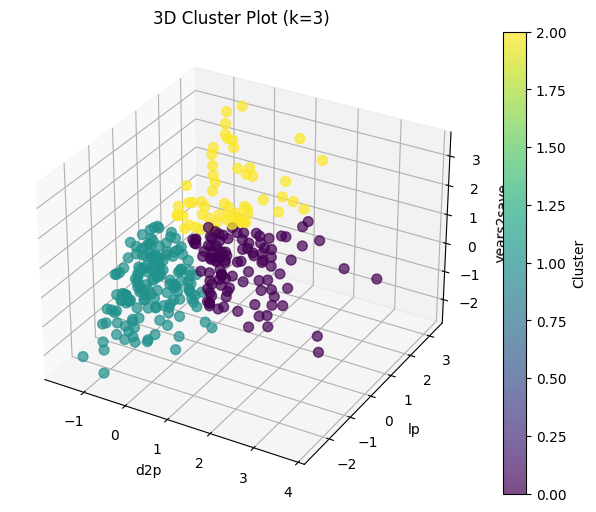

K-Means with a bit higher cluster count. Most well rounded score within k-means
Columns: ('lp', 'sal_to_lst', 'years2save'), K: 13


<Figure size 800x600 with 0 Axes>

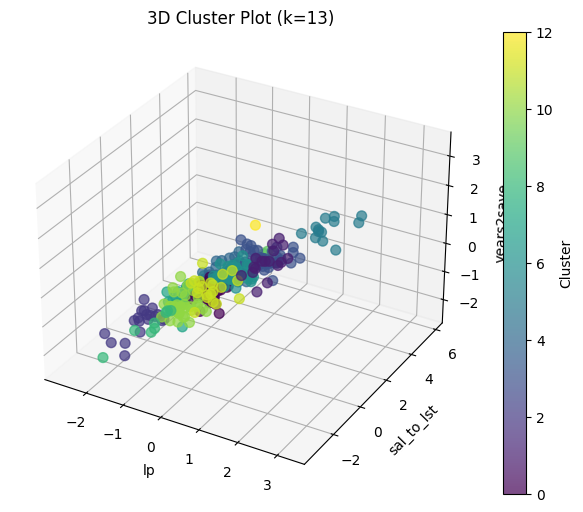

K-Means with a cluster count between previous choices. This option excludes both lp AND years2save
Columns: ('d2p', 'lp', 'sal_to_lst'), K: 8


<Figure size 800x600 with 0 Axes>

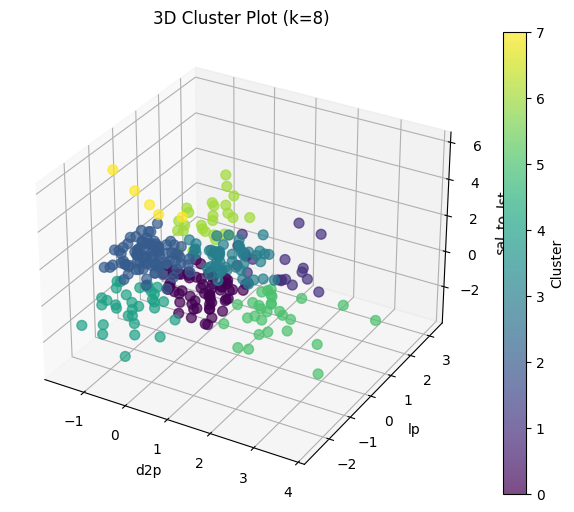

Hierarchial clustering with best scores
Columns: ('fsi', 'sal_to_lst', 'share_lst_price_cut'), K: 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<Figure size 800x600 with 0 Axes>

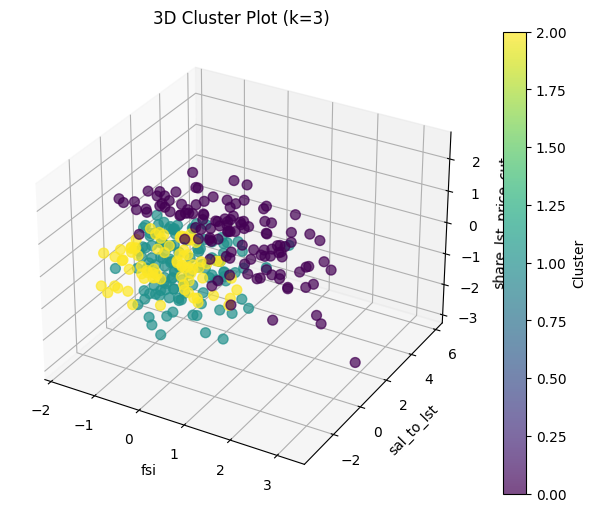

,fsi,d2p,lp,sal_to_lst,share_lst_price_cut,years2save,cluster_label
0,10.611573,30.0,13.451669,1.000000,0.130736,2.652507,0
1,9.640043,17.0,13.813510,1.000000,0.177133,3.020465,0
2,9.975808,14.0,12.691584,1.000000,0.240755,2.080524,0
3,10.038106,27.0,12.957649,0.987013,0.295485,2.254230,0
4,10.025617,28.0,12.765691,0.982353,0.246670,2.163349,0
...,...,...,...,...,...,...,...
313,5.198497,8.0,11.669510,0.970565,0.177778,1.538828,2
314,5.424950,34.0,12.896719,0.988175,0.190265,2.366100,1
315,5.347108,17.0,12.203575,0.994269,0.196172,1.591415,1
316,5.252273,20.0,13.026955,0.983607,0.278947,2.404125,0


In [23]:
print(f'K-Means with reaasonable cluster count. WCSS higher than other options')
columns = k_means_df.iloc[1152]["columns"]
k = k_means_df.iloc[1152]["k"]
print(f'Columns: {columns}, K: {k}')
best_score_results = plot_clusters(k_means_df, columns, k, algorithm_type='kmeans', apply_pca=False, n_pca_components=2).copy()

print(f'K-Means with a bit higher cluster count. Most well rounded score within k-means')
columns = k_means_df.iloc[1715]["columns"]
k = k_means_df.iloc[1715]["k"]
print(f'Columns: {columns}, K: {k}')
plot_clusters(k_means_df, columns, k, algorithm_type='kmeans', apply_pca=False, n_pca_components=2)

print(f'K-Means with a cluster count between previous choices. This option excludes both lp AND years2save')
columns = k_means_df.iloc[1002]["columns"]
k = k_means_df.iloc[1002]["k"]
print(f'Columns: {columns}, K: {k}')
plot_clusters(k_means_df, columns, k, algorithm_type='kmeans', apply_pca=False, n_pca_components=2)

print(f'Hierarchial clustering with best scores')
columns = agglo_df.iloc[590]["columns"]
k = agglo_df.iloc[590]["k"]
print(f'Columns: {columns}, K: {k}')
plot_clusters(agglo_df, columns, k, algorithm_type='agglomerative', apply_pca=False, n_pca_components=2)

**All plots below have more than three features and utilize PCA with two components**

Hierarchial clustering with more than three features
Columns: ('fsi', 'd2p', 'lp', 'sal_to_lst'), K: 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


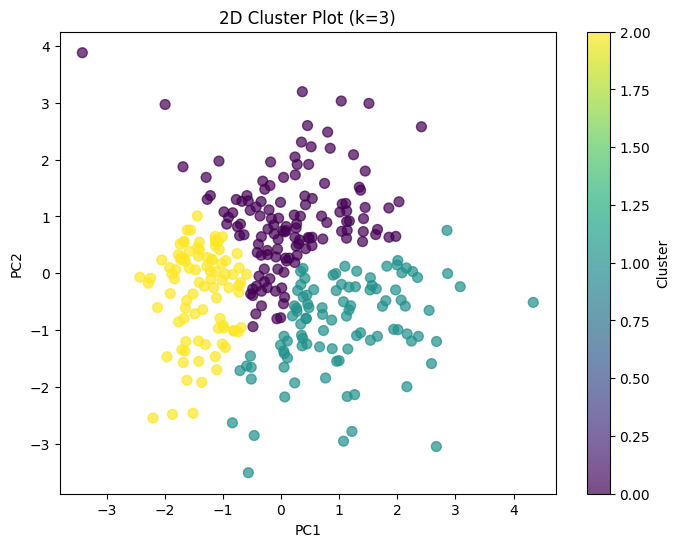

K-Means with more than three features and the best score
Columns: ('d2p', 'lp', 'sal_to_lst', 'years2save'), K: 3


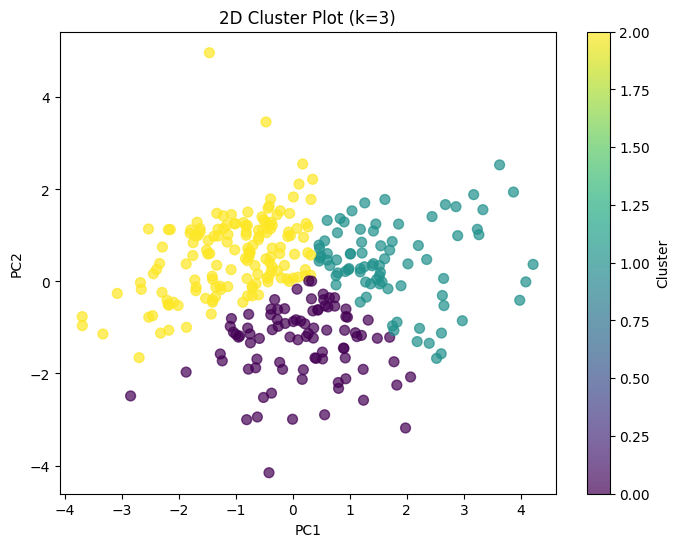

,fsi,d2p,lp,sal_to_lst,share_lst_price_cut,years2save,cluster_label
0,10.611573,30.0,13.451669,1.000000,0.130736,2.652507,1
1,9.640043,17.0,13.813510,1.000000,0.177133,3.020465,1
2,9.975808,14.0,12.691584,1.000000,0.240755,2.080524,2
3,10.038106,27.0,12.957649,0.987013,0.295485,2.254230,0
4,10.025617,28.0,12.765691,0.982353,0.246670,2.163349,0
...,...,...,...,...,...,...,...
313,5.198497,8.0,11.669510,0.970565,0.177778,1.538828,2
314,5.424950,34.0,12.896719,0.988175,0.190265,2.366100,0
315,5.347108,17.0,12.203575,0.994269,0.196172,1.591415,2
316,5.252273,20.0,13.026955,0.983607,0.278947,2.404125,1


In [24]:
print(f'Hierarchial clustering with more than three features')
columns = agglo_df.iloc[1684]["columns"]
k = agglo_df.iloc[1684]["k"]
print(f'Columns: {columns}, K: {k}')
plot_clusters(agglo_df, columns, k, algorithm_type='agglomerative', apply_pca=True, n_pca_components=2)

print(f'K-Means with more than three features and the best score')
columns = k_means_df.iloc[2980]["columns"]
k = k_means_df.iloc[2980]["k"]
print(f'Columns: {columns}, K: {k}')
plot_clusters(k_means_df, columns, k, algorithm_type='kmeans', apply_pca=True, n_pca_components=2)

**All plots below have more than three features and utilize PCA with three components**

Hierarchial clustering with more than three features
Columns: ('fsi', 'd2p', 'lp', 'sal_to_lst'), K: 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


<Figure size 800x600 with 0 Axes>

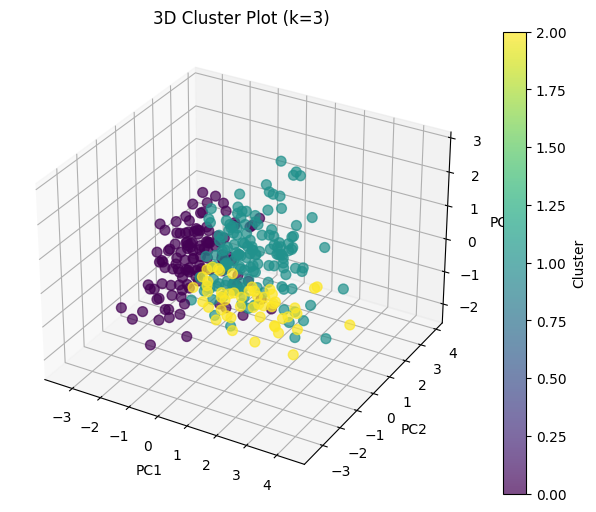

K-Means with more than three features and the best score
Columns: ('d2p', 'lp', 'sal_to_lst', 'years2save'), K: 3


<Figure size 800x600 with 0 Axes>

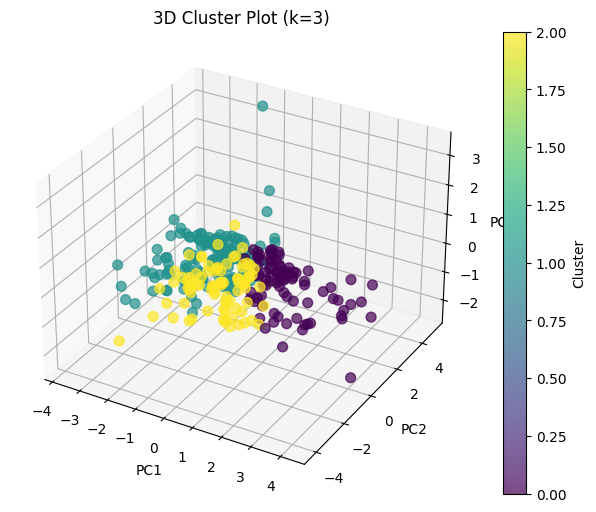

,fsi,d2p,lp,sal_to_lst,share_lst_price_cut,years2save,cluster_label
0,10.611573,30.0,13.451669,1.000000,0.130736,2.652507,0
1,9.640043,17.0,13.813510,1.000000,0.177133,3.020465,0
2,9.975808,14.0,12.691584,1.000000,0.240755,2.080524,1
3,10.038106,27.0,12.957649,0.987013,0.295485,2.254230,2
4,10.025617,28.0,12.765691,0.982353,0.246670,2.163349,2
...,...,...,...,...,...,...,...
313,5.198497,8.0,11.669510,0.970565,0.177778,1.538828,1
314,5.424950,34.0,12.896719,0.988175,0.190265,2.366100,2
315,5.347108,17.0,12.203575,0.994269,0.196172,1.591415,1
316,5.252273,20.0,13.026955,0.983607,0.278947,2.404125,0


In [25]:
print(f'Hierarchial clustering with more than three features')
columns = agglo_df.iloc[1684]["columns"]
k = agglo_df.iloc[1684]["k"]
print(f'Columns: {columns}, K: {k}')
plot_clusters(agglo_df, columns, k, algorithm_type='agglomerative', apply_pca=True, n_pca_components=3)

print(f'K-Means with more than three features and the best score')
columns = k_means_df.iloc[2980]["columns"]
k = k_means_df.iloc[2980]["k"]
print(f'Columns: {columns}, K: {k}')
plot_clusters(k_means_df, columns, k, algorithm_type='kmeans', apply_pca=True, n_pca_components=3)

# Conclusions

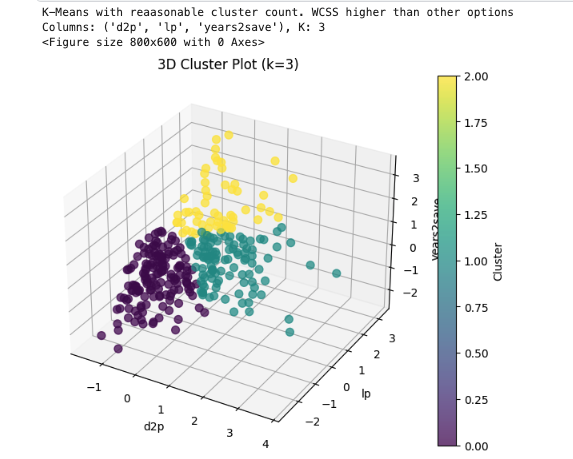

Cluster 1 (purple): These are likely houses with lower listing prices, shorter days to pending, and shorter saving periods. This could represent more affordable homes in high-demand areas, starter homes, or properties that are priced competitively. They sell quickly and are accessible to buyers who haven't been saving for very long.

Cluster 2 (yellow): These houses fall in the middle range for all three features. They might be moderately priced homes in less competitive areas or properties with some desirable features but also some drawbacks. They take a reasonable amount of time to sell and are attainable for buyers with a moderate savings history.

Cluster 3 (teal): These are likely houses with higher listing prices, longer days to pending, and longer saving periods. This cluster could represent luxury homes, properties in less desirable locations, or houses that are overpriced.  They tend to stay on the market longer and require buyers to have saved for a longer time

In [26]:
best_score_results['RegionID'] = region_ids
best_score_results['RegionName'] = region_names
top_10_per_label = best_score_results.groupby('cluster_label').apply(lambda x: x.head(5)).reset_index(drop=True)
display(top_10_per_label)

<ipython-input-26-c42e3b6fe75d>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_per_label = best_score_results.groupby('cluster_label').apply(lambda x: x.head(5)).reset_index(drop=True)


,fsi,d2p,lp,sal_to_lst,share_lst_price_cut,years2save,cluster_label,RegionID,RegionName
0,10.038106,27.0,12.957649,0.987013,0.295485,2.254230,0,394514,"Dallas, TX"
1,10.025617,28.0,12.765691,0.982353,0.246670,2.163349,0,394692,"Houston, TX"
2,9.924809,26.0,12.834684,0.995349,0.256632,2.231339,0,394347,"Atlanta, GA"
3,9.763536,29.0,13.132316,0.988235,0.297981,2.436386,0,394976,"Phoenix, AZ"
4,8.993552,30.0,12.807381,1.000000,0.261615,2.147944,0,394865,"Minneapolis, MN"
5,9.975808,14.0,12.691584,1.000000,0.240755,2.080524,1,394463,"Chicago, IL"
6,9.431241,14.0,12.672950,1.000000,0.237270,2.184242,1,394974,"Philadelphia, PA"
7,9.365633,14.0,12.323362,1.000000,0.235380,2.012495,1,394532,"Detroit, MI"
8,8.652598,13.0,12.721889,1.000000,0.252271,2.179653,1,394358,"Baltimore, MD"
9,8.840435,11.0,12.250094,1.000000,0.253945,1.962730,1,395121,"St. Louis, MO"
